In [ ]:
# Importar las librerias necesarias
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle



In [ ]:
# Cargar los  datasets (ambos en formato CSV)
df_csv_new = pd.read_csv('DataViolence.csv')
df_csv_encuesta_new = pd.read_csv('encuestaViolenceCorrecto.csv')
# Mostrar las primeras filas de ambos datasets y las columnas para entender su estructura
df_csv_new_info = (df_csv_new.head(), df_csv_new.columns)
df_csv_encuesta_new_info = (df_csv_encuesta_new.head(), df_csv_encuesta_new.columns)

df_csv_new_info, df_csv_encuesta_new_info

((   sujeto genero  edad edo_civil  carrera  semestre  discapacidad  lengua  \
  0      30      F    25   SOLTERO       14         9             1       1   
  1      30      F    25   SOLTERO       14         9             1       1   
  2      30      F    25   SOLTERO       14         9             1       1   
  3     198      F    28   SOLTERO        3        13             1       1   
  4     198      F    28   SOLTERO        3        13             1       1   
  
     esc_proc  prom  ant_aca  gusto  familia  tipo_f  vivienda     cuenta  
  0        68  90.0     2690    2.0      2.0     1.0       1.0  201607026  
  1        68  90.0     2690    2.0      2.0     1.0       1.0  201607026  
  2        68  90.0     2690    2.0      2.0     1.0       1.0  201607026  
  3         0   0.0     1548    1.0      1.0     1.0       1.0  201617010  
  4         0   0.0     1548    1.0      1.0     1.0       1.0  201617010  ,
  Index(['sujeto', 'genero', 'edad', 'edo_civil', 'carrera', 'seme

In [ ]:
# Convertir la columna 'Cuenta' a string y quitar cualquier '.0' al final para coincidir con el otro DataFrame
df_csv_encuesta_new['Cuenta'] = df_csv_encuesta_new['Cuenta'].astype(str).str.replace('.0', '', regex=False)

# Renombrar la columna para coincidir con el otro DataFrame
df_csv_encuesta_new_renamed = df_csv_encuesta_new.rename(columns={"Cuenta": "cuenta"})

# Convertir la columna 'cuenta' en df_csv_new a string (si no lo es ya)
df_csv_new['cuenta'] = df_csv_new['cuenta'].astype(str)

# Realizar el merge para hacer coincidir la hoja de datos completa con la encuesta recabada de las personas que han sufrido violenci
merged_df_new = pd.merge(df_csv_new, df_csv_encuesta_new_renamed, on='cuenta', how='inner')

# Mostrar las primeras filas del DataFrame resultante
merged_df_new.head()


,sujeto,genero,edad,edo_civil,carrera,semestre,discapacidad,lengua,esc_proc,prom,ant_aca,gusto,familia,tipo_f,vivienda,cuenta,tipo,frecuencia
0,2703,F,22,SOLTERO,1,8,1,1,6,8.5,2323,1.0,1.0,3.0,1.0,202001044,Sexual,1.0
1,2703,F,22,SOLTERO,1,8,1,1,6,8.5,2323,1.0,1.0,3.0,1.0,202001044,Sexual,1.0
2,2733,M,21,SOLTERO,13,8,1,1,1,8.8,974,1.0,1.0,2.0,1.0,202035031,Física,1.0
3,2733,M,21,SOLTERO,13,8,1,1,1,8.8,974,1.0,1.0,2.0,1.0,202035031,Física,1.0
4,2736,M,21,SOLTERO,13,8,1,1,1,7.9,1100,1.0,1.0,2.0,1.0,202035033,Verbal,1.0


In [ ]:
merged_csv_path = 'MergedViolenceData.csv'
merged_df_new.to_csv(merged_csv_path, index=False)
merged_csv_path
data = pd.read_csv('MergedViolenceData.csv')

In [ ]:
#preprocesamiento
# Seleccionar columnas para eliminar y columnas categóricas para la codificación
columns_to_drop = ['sujeto', 'cuenta']
categorical_features = ['genero', 'edo_civil']
numeric_features = ['edad', 'carrera', 'semestre', 'discapacidad', 'lengua', 'esc_proc', 'prom',
                    'ant_aca', 'gusto', 'familia', 'tipo_f', 'vivienda']

# Preparar el preprocesador con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Preparar el pipeline completo
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Preparar los datos
X = data.drop(columns=['tipo'] + columns_to_drop)
y = data['tipo']

# Codificar la variable objetivo
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Aplicar la transformación
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

X_train_prepared.shape, X_test_prepared.shape, y_train.shape, y_test.shape


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((199, 16), (50, 16), (199, 11), (50, 11))

In [ ]:
# Definición del modelo
model = Sequential([
    Dense(64, input_dim=X_train_prepared.shape[1], activation='relu'),  # Capa de entrada y primera capa oculta
    Dense(64, activation='relu'),  # Segunda capa oculta
    Dense(y_train.shape[1], activation='softmax')  # Capa de salida
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Entrenamiento del modelo
history = model.fit(X_train_prepared, y_train, epochs=100, validation_split=0.2, batch_size=10)


Epoch 1/100
16/16 [==============================] - 2s 39ms/step - loss: 2.2548 - accuracy: 0.2453 - val_loss: 2.1711 - val_accuracy: 0.4000
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 1.9522 - accuracy: 0.4340 - val_loss: 2.0010 - val_accuracy: 0.4250
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 1.7763 - accuracy: 0.4277 - val_loss: 1.9043 - val_accuracy: 0.4500
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 1.6705 - accuracy: 0.4465 - val_loss: 1.8578 - val_accuracy: 0.4250
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 1.5916 - accuracy: 0.4591 - val_loss: 1.8232 - val_accuracy: 0.4000
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 1.5220 - accuracy: 0.4969 - val_loss: 1.7989 - val_accuracy: 0.4000
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 1.4616 - accuracy: 0.5220 - val_loss: 1.7678 - val_accuracy: 0.4000
Epoch 8/1

In [ ]:
# Obtener las predicciones para el conjunto de prueba
y_pred_probs = model.predict(X_test_prepared)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convertir probabilidades a etiquetas de clase
y_true = np.argmax(y_test, axis=1)  # Convertir one-hot a etiquetas de clase

# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


2/2 [==============================] - 0s 8ms/step
Accuracy: 0.78
Precision: 0.6666666666666667
Recall: 0.6282913165266107
F1 Score: 0.6453879170715905


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 0s 6ms/step


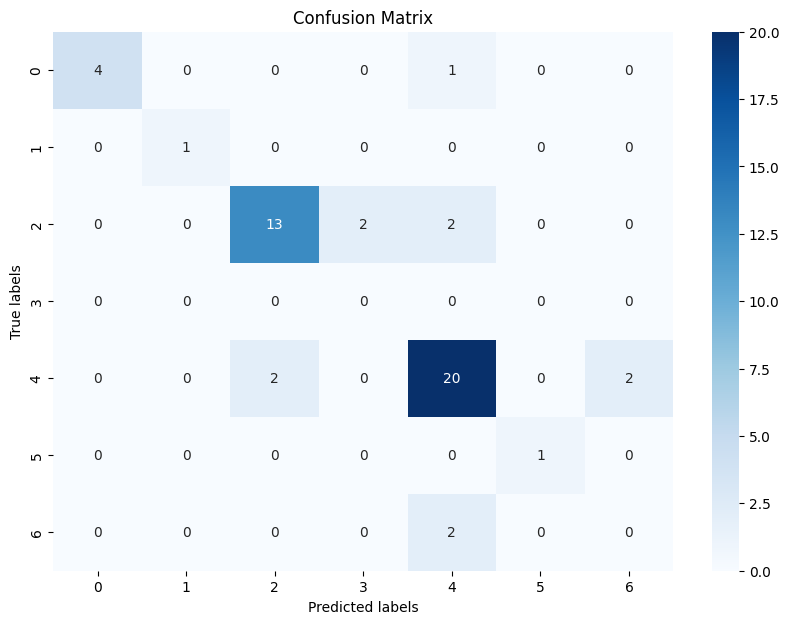

In [ ]:
y_pred = np.argmax(model.predict(X_test_prepared), axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
# Guarda la figura ANTES de llamar a plt.show()
plt.savefig('matriz_violenceRN.png')  # Cambia la ruta si estás usando Google Colab
plt.show()


2/2 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


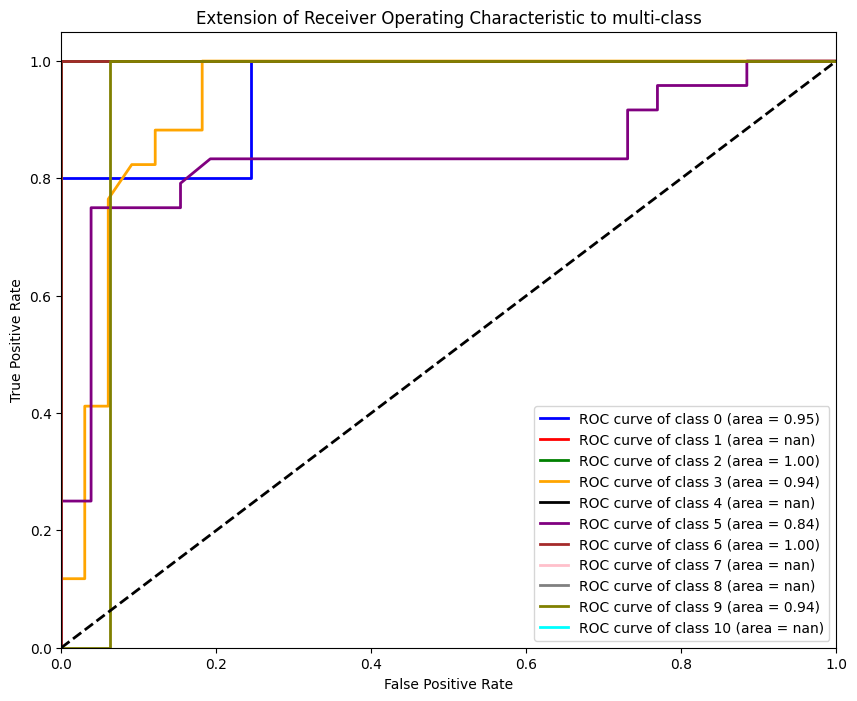

[5 3 3 5 5 5 0 3 3 9 0 2 4 3 5 6 5 5 3 5 3 5 3 5 0 0 3 3 5 5 4 5 5 5 5 5 5
 5 3 5 5 3 9 3 5 5 5 3 3 5]


In [ ]:
y_pred_probs = model.predict(X_test_prepared)

# Número de clases
n_classes = y_pred_probs.shape[1]

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Colores para las diferentes clases
colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])

# Plot de la curva ROC para cada clase
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve.png')
plt.show()

In [ ]:
y_pred_probs = model.predict(X_test_prepared)

# Número de clases
n_classes = y_pred_probs.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print("Datos de la Curva ROC y AUC para cada clase:")
for i in range(n_classes):
    print(f"Clase {i}: FPR: {fpr[i]}, TPR: {tpr[i]}, AUC: {roc_auc[i]}")


2/2 [==============================] - 0s 5ms/step
Datos de la Curva ROC y AUC para cada clase:
Clase 0: FPR: [0.         0.         0.         0.         0.02222222 0.15555556
 0.24444444 0.24444444 0.35555556 0.44444444 0.46666667 0.51111111
 0.53333333 0.62222222 0.8        0.86666667 1.        ], TPR: [0.  0.2 0.6 0.8 0.8 0.8 0.8 1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ], AUC: 0.9511111111111112
Clase 1: FPR: [0.   0.06 0.14 0.26 0.3  0.38 0.5  0.54 0.62 0.72 0.76 0.8  0.84 1.  ], TPR: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan], AUC: nan
Clase 2: FPR: [0.         0.         0.04081633 0.18367347 0.26530612 0.32653061
 0.3877551  0.46938776 0.57142857 0.6122449  0.63265306 0.71428571
 0.75510204 0.79591837 0.83673469 0.87755102 1.        ], TPR: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], AUC: 1.0
Clase 3: FPR: [0.         0.         0.         0.03030303 0.03030303 0.06060606
 0.06060606 0.06060606 0.06060606 0.09090909 0.12121212 0.12121212
 0.18181818 0.18

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
